In [1]:
%load_ext autoreload
%autoreload 2

import jax
jax.config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)

import numpy as np
import scipy.optimize

import ultraplot as uplt

## Fit the Data w/ G(z)

In [2]:
from des_y6_imsim_analysis import bump
from des_y6_imsim_analysis.utils import read_data

data = read_data("../../data/N_gamma_alpha_v2_statistical.hdf5")

model_module = bump

model_data = model_module.make_model_data(
    z=data.z,
    nzs=data.nzs,
    mn=data.mn,
    cov=data.cov,
    mn_pars=data.mn_pars,
    zbins=data.zbins,
    fixed_param_values={"w": 0.1},
    num_bins=7,
)

In [3]:
from des_y6_imsim_analysis.stats import measure_map

map_params = measure_map(
    model_module=model_module,
    model_data=model_data,
    seed=23141,
    progress_bar=True,
)

100%|██████████| 50000/50000 [00:23<00:00, 2099.12it/s, init loss: 138619.0577, avg. loss [47501-50000]: -137.5871]


In [4]:
import pprint

from des_y6_imsim_analysis.stats import compute_model_chi2_info

chi2_info = compute_model_chi2_info(
    model_module=model_module,
    model_data=model_data,
    data=data,
    params=map_params,
)

print("chi2:", chi2_info['chi2'])
print("dof:", chi2_info['dof'])
print("p-value:", chi2_info['p_value'])
print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
    (chi2_info['model_mn'][:4] - 1).tolist(),
    (data.mn[:4] - 1).tolist(),
    (np.sqrt(np.diag(data.cov)[:4])).tolist(),
))
print("map params:\n", pprint.pformat(map_params))

chi2: 17.308633121384624
dof: 12
p-value: 0.13835173789260874
m vals:
    model: [-0.007035364762222662, 0.013380733692742286, 0.01692467207968984, 0.011704026549860469]
    data: [-0.006994349826206503, 0.016036566228740057, 0.017247239530250313, 0.009428620061380233]
     err: [0.004593226944328782, 0.006142812018330256, 0.005437871858005932, 0.009363355942622971]
map params:
 {'a0_b0': Array(-0.03773022, dtype=float64),
 'a0_b1': Array(0.08107821, dtype=float64),
 'a0_b2': Array(-1.28828432, dtype=float64),
 'a0_b3': Array(-0.33210817, dtype=float64),
 'a1_b0': Array(0.39647715, dtype=float64),
 'a1_b1': Array(-0.00183015, dtype=float64),
 'a1_b2': Array(0.15793444, dtype=float64),
 'a1_b3': Array(0.04254621, dtype=float64),
 'a2_b0': Array(0.04232769, dtype=float64),
 'a2_b1': Array(0.08493813, dtype=float64),
 'a2_b2': Array(-0.06353358, dtype=float64),
 'a2_b3': Array(0.06515748, dtype=float64),
 'a3_b0': Array(-0.22303854, dtype=float64),
 'a3_b1': Array(-0.08218476, dtype=float

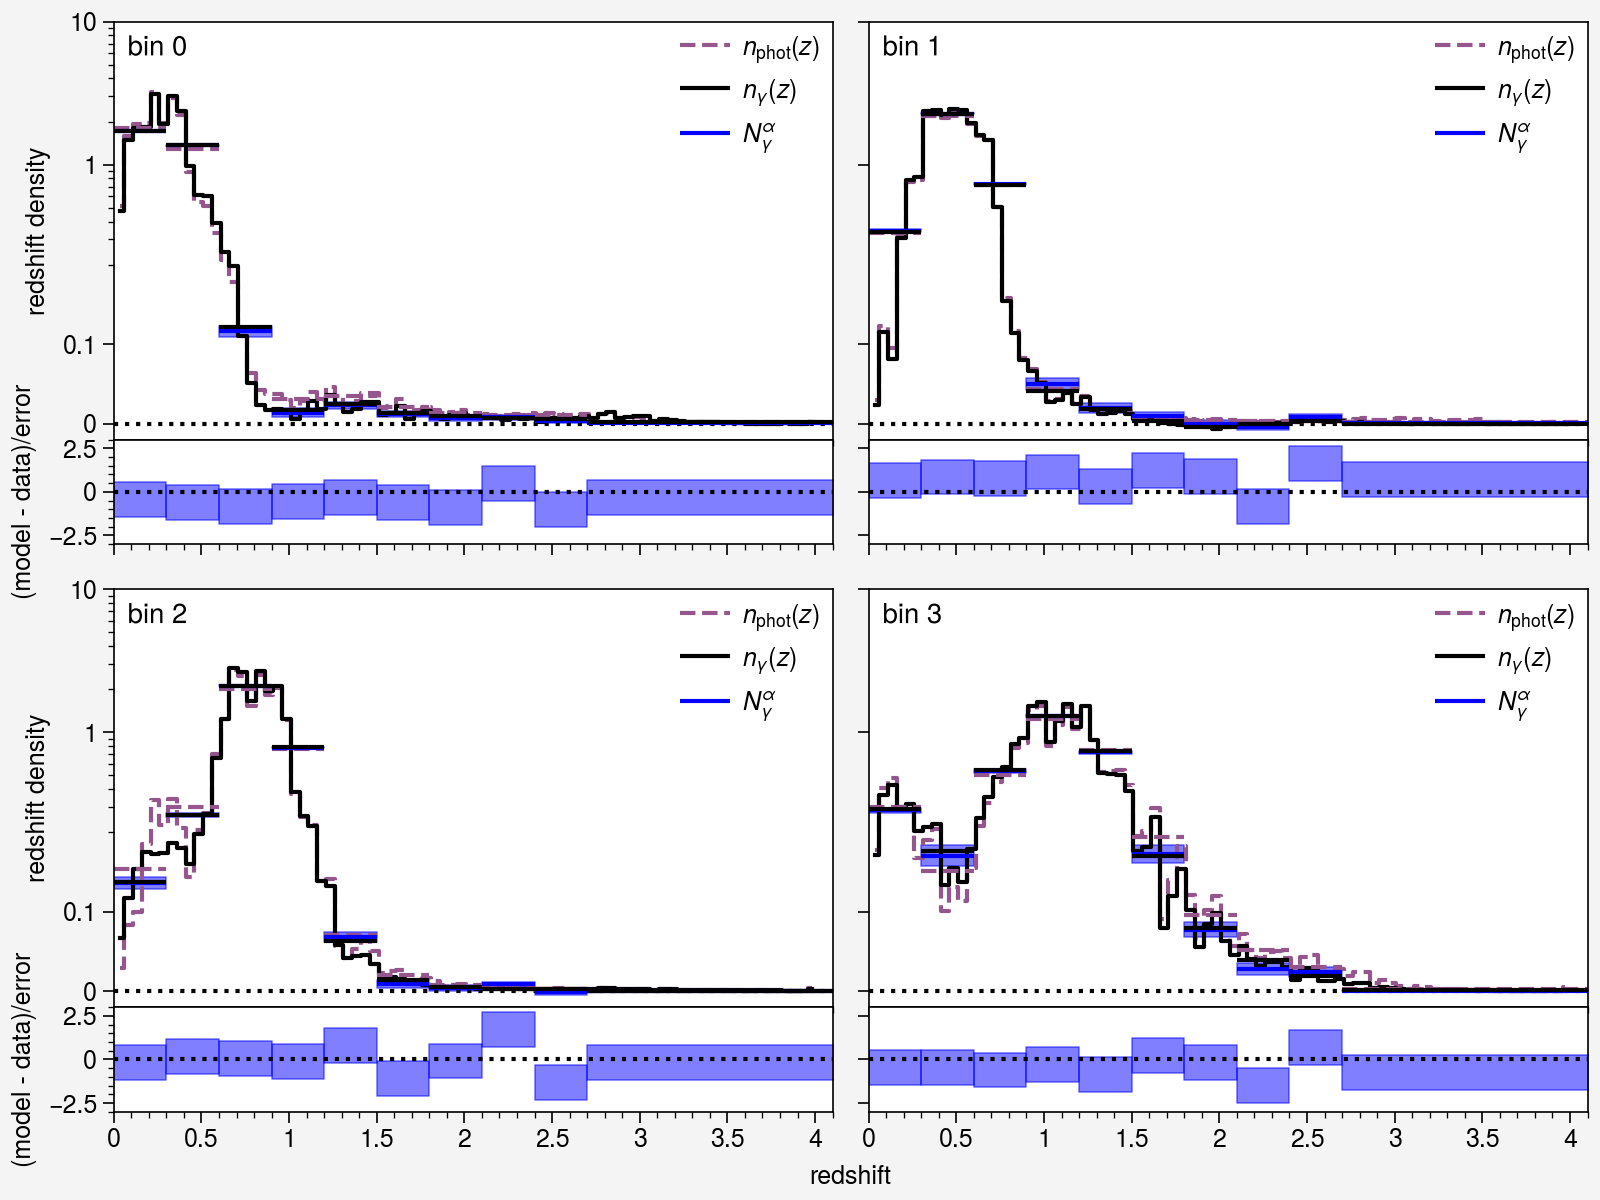

In [5]:
from des_y6_imsim_analysis.utils import plot_results

fig = plot_results(model_module=model_module, model_data=model_data, map_params=map_params)

In [6]:
from des_y6_imsim_analysis.stats import run_mcmc

mcmc = run_mcmc(
    model_module=model_module,
    model_data=model_data,
    init_params=map_params,
    seed=23141,
    progress_bar=True,
    dense_mass=True,
)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [7]:
mcmc.print_summary(exclude_deterministic=False)
samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0     -0.04      0.02     -0.04     -0.07     -0.01   4289.62      1.00
     a0_b1      0.08      0.05      0.08     -0.01      0.16   3717.80      1.00
     a0_b2     -1.28      0.34     -1.28     -1.83     -0.70   4003.73      1.00
     a0_b3     -0.33      0.17     -0.33     -0.62     -0.06   4016.87      1.00
     a1_b0      0.40      0.03      0.40      0.34      0.45   5405.38      1.00
     a1_b1     -0.00      0.05     -0.00     -0.08      0.07   3962.62      1.00
     a1_b2      0.16      0.03      0.16      0.11      0.20   4086.67      1.00
     a1_b3      0.04      0.06      0.04     -0.06      0.14   4309.12      1.00
     a2_b0      0.05      0.31      0.05     -0.46      0.54   3717.61      1.00
     a2_b1      0.08      0.33      0.08     -0.47      0.60   3270.06      1.00
     a2_b2     -0.06      0.04     -0.06     -0.12     -0.00   4208.06      1.00
     a2_b3      0.06      0

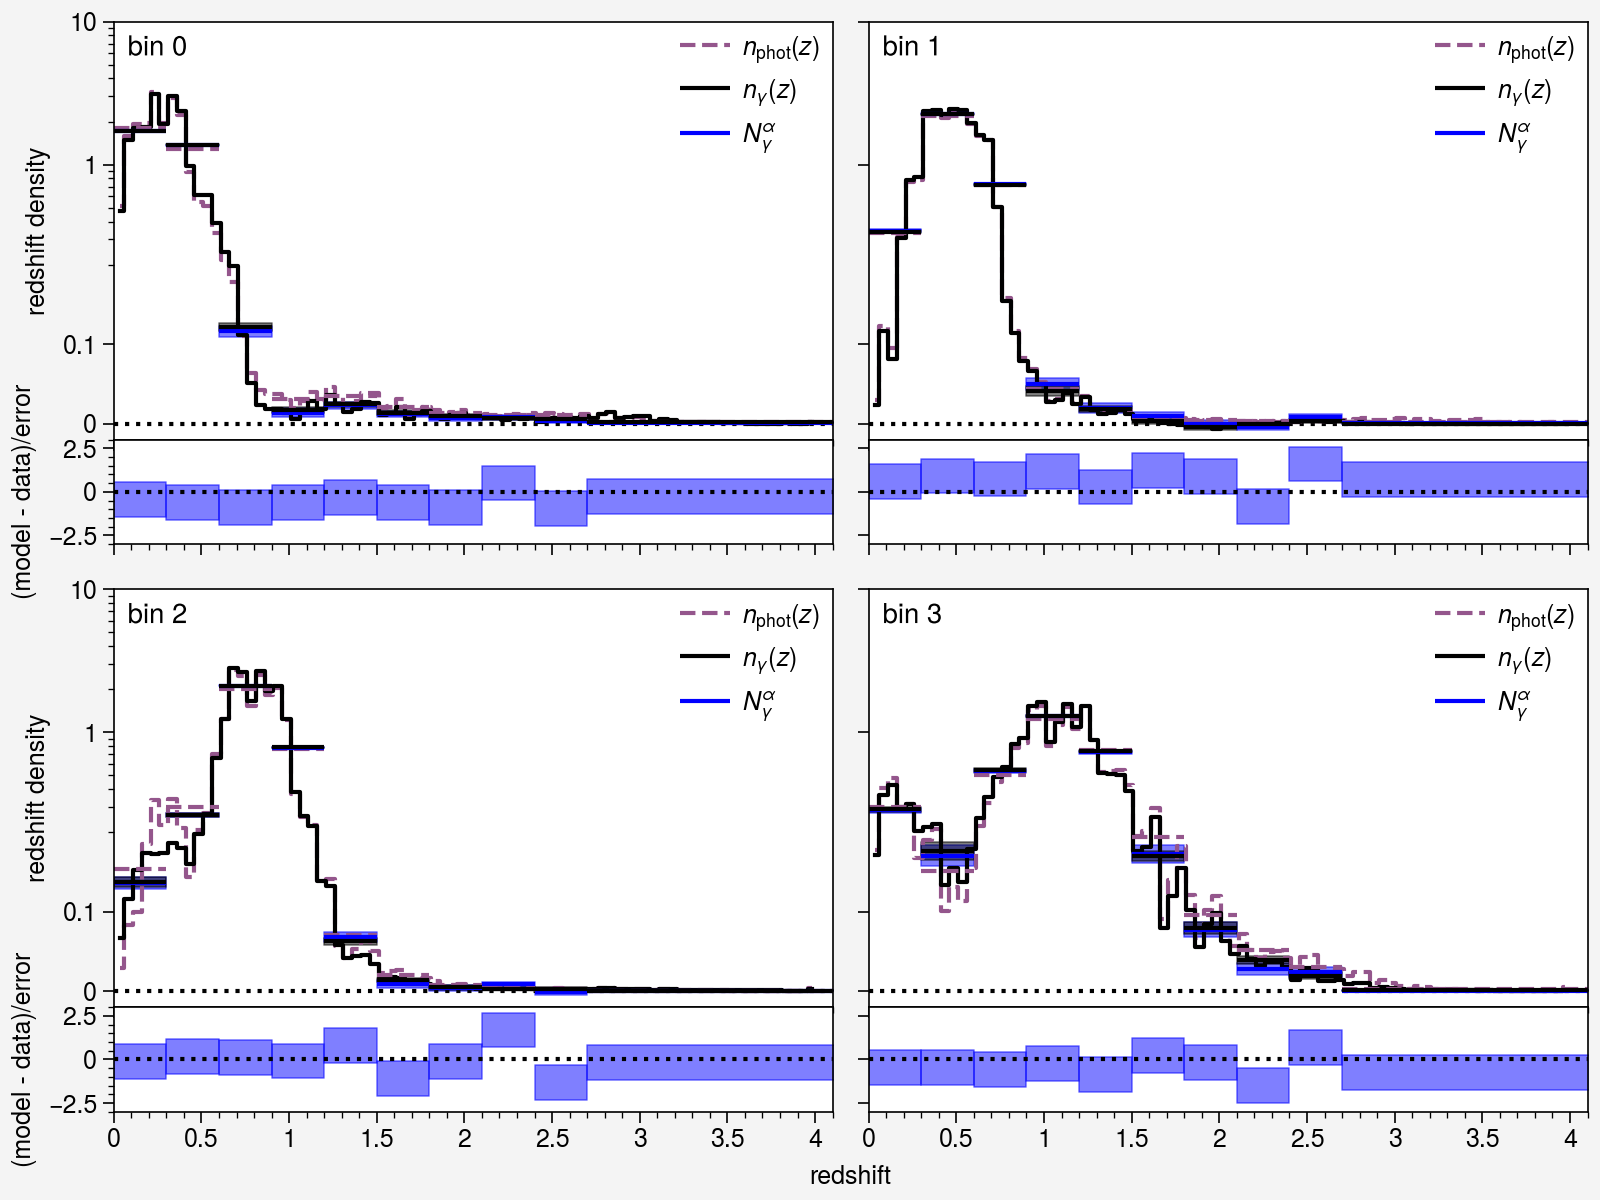

In [8]:
fig = plot_results(model_module=model_module, model_data=model_data, samples=samples)

In [9]:
from des_y6_imsim_analysis.utils import measure_m_dz

mdz = measure_m_dz(
    model_module=model_module,
    model_data=model_data,
    samples=samples,
    return_dict=True,
)

In [10]:
m_mn = [np.mean(mdz[f"m_b{i}"]) for i in range(4)]
m_sd = [np.std(mdz[f"m_b{i}"]) for i in range(4)]

dz_mn = [np.mean(mdz[f"dz_b{i}"]) for i in range(4)]
dz_sd = [np.std(mdz[f"dz_b{i}"]) for i in range(4)]

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  -7.1 +/- 13.7    | -0.009 +/- 0.004 |
| 1   | +13.1 +/- 17.4    | -0.022 +/- 0.005 |
| 2   | +16.8 +/- 15.4    | +0.003 +/- 0.005 |
| 3   | +11.6 +/- 28.0    | -0.032 +/- 0.008 |
|--------------------------------------------|


mdz_arr shape: (1000, 8)
(8, 8)


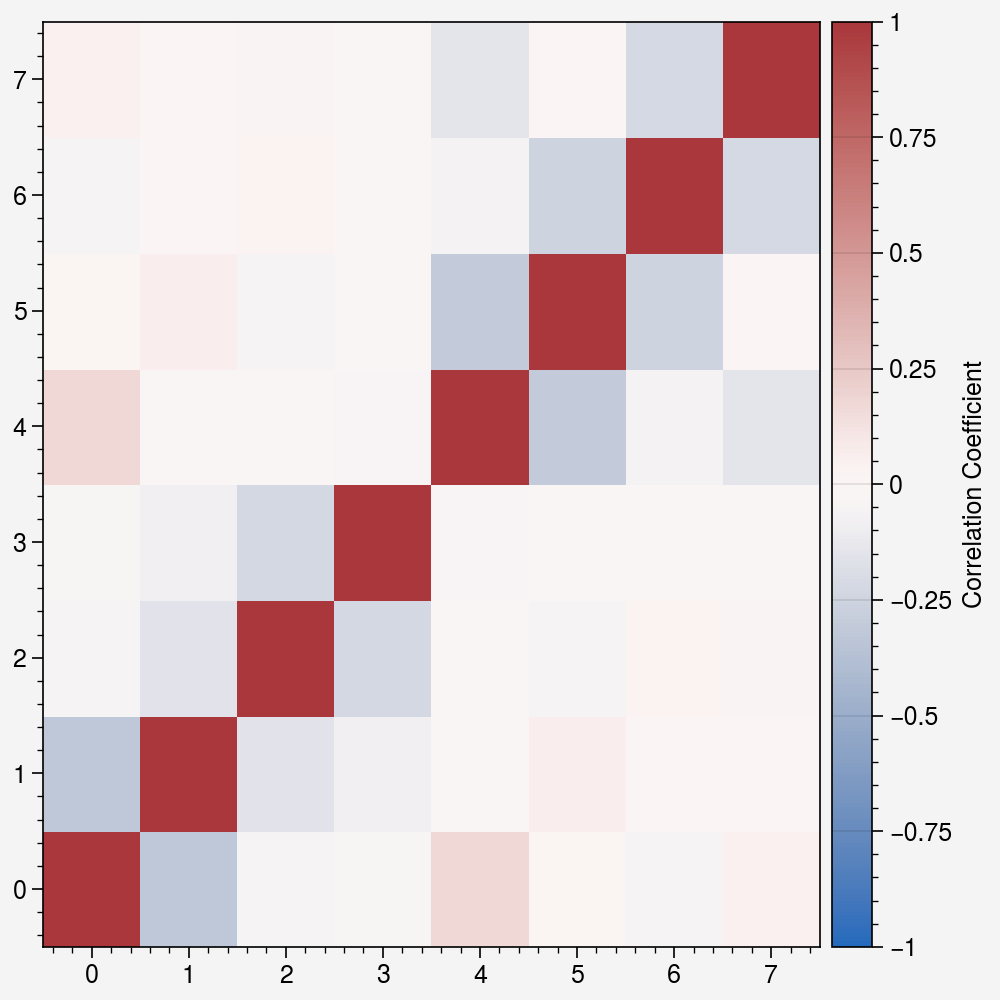

In [11]:
mdz_arr = np.vstack(
    [mdz[f"m_b{i}"] for i in range(4)]
    + [mdz[f"dz_b{i}"] for i in range(4)],
).T
print("mdz_arr shape:", mdz_arr.shape)

corr = np.corrcoef(mdz_arr.T)
print(corr.shape)

fig, axs = uplt.subplots(figsize=(5, 5))

m = axs.pcolormesh(corr, vmin=-1, vmax=1, cmap="vlag", discrete=False)
axs.colorbar(m, label="Correlation Coefficient")
axs.format(grid=False)

Bad value in file PosixPath('/Users/beckermr/mambaforge/envs/des-y6/lib/python3.11/site-packages/arviz/plots/styles/arviz-grayscale.mplstyle'), line 33 ('image.cmap: cet_gray #  perceptually uniform gray scale from colorcet (linear_grey_10_95_c0)'): 'image.cmap is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'


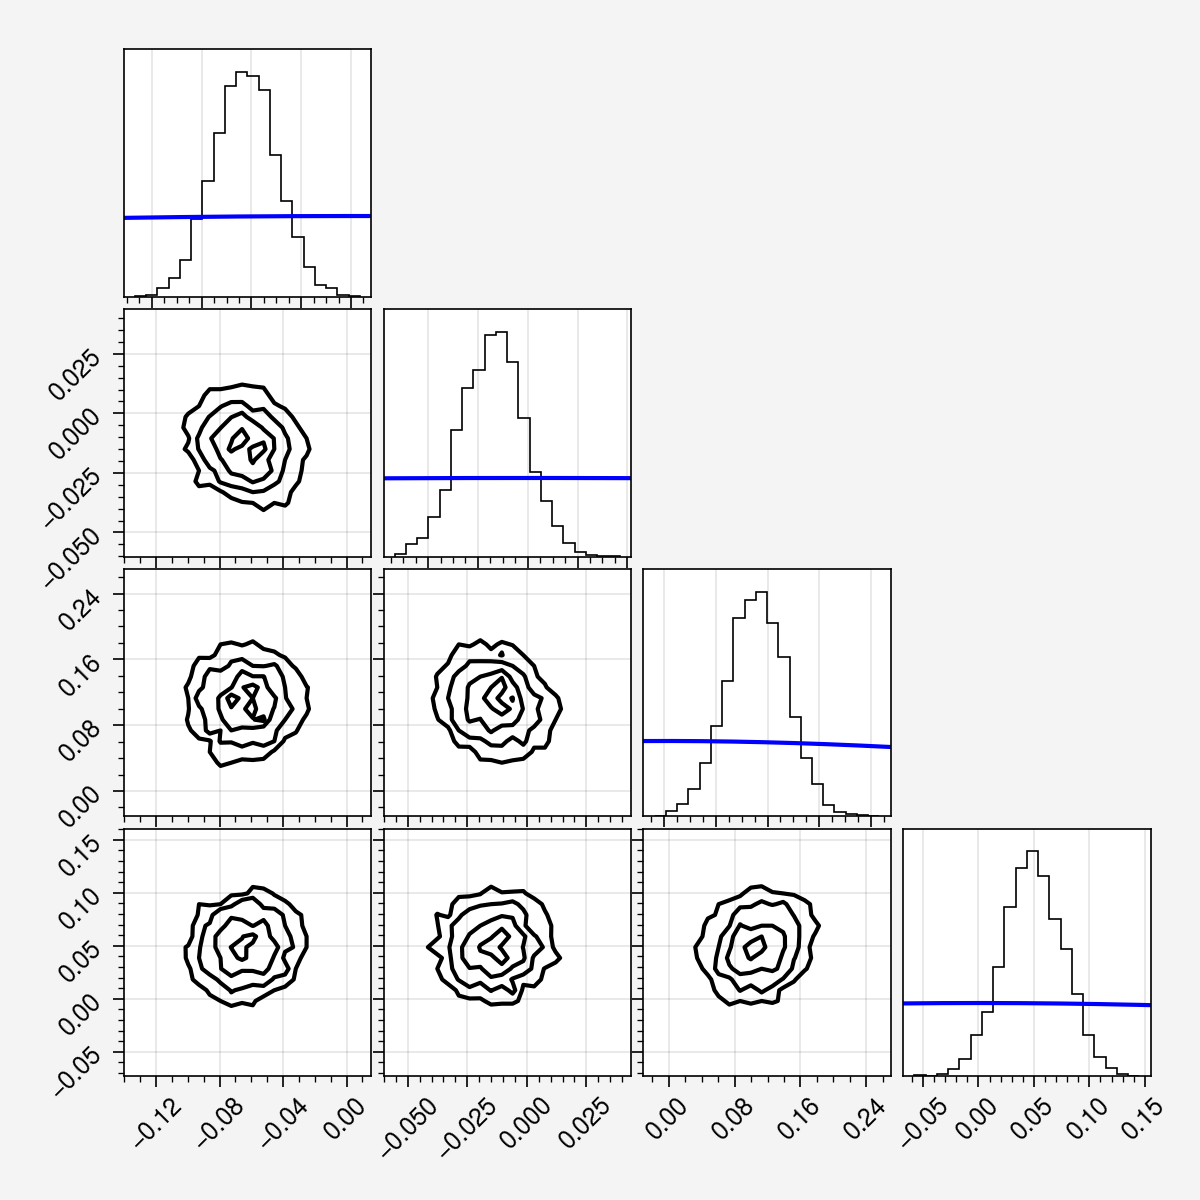

In [12]:
import corner
from matplotlib import pyplot as plt


def softlaplace(x, loc=0, scale=1):
    z = (x - loc) / scale
    return 2.0 * np.pi / scale / (np.exp(z) + np.exp(-z))


total = []
for k in map_params.keys():
    if k == "w" or k.startswith("a"):
        continue
    total.append(samples[k].flatten())
nd = len(total)
total = np.array(total).T

kwargs = {"alpha": 0.25}

fig, axs = plt.subplots(nrows=nd, ncols=nd, figsize=(6, 6))
corner.corner(total, fig=fig, plot_datapoints=False, plot_density=False);

for i in range(nd):
    ax = axs[i, i]
    x = np.linspace(
        -1, 1, 10000,
    )
    ax.plot(x, softlaplace(x, loc=0, scale=2.0 / np.pi) * 0.01 * samples[k].shape[0], color="blue")

# Compute Global `m`

```text
g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0

['statistical_weight']
b 	 w 			 w * R
0 	 37687408.52750142 	 31852021.778152555
1 	 32262590.501660284 	 25166769.445796162
2 	 36321284.070149 	 28019787.27996662
3 	 22979366.319672316 	 14517510.901062118

['statistical_weight', 'neighbor_weight']
b 	 w 			 w * R
0 	 36935272.88896909 	 31258164.71036748
1 	 33630265.55123577 	 26647800.06951995
2 	 37616957.073409796 	 29500162.15844555
3 	 23442093.917962722 	 15133209.390449103

['statistical_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38270056.368683755 	 32061262.610645365
1 	 35022342.94013908 	 27517630.555414688
2 	 30616116.814313516 	 23831877.593959697
3 	 25344050.202425964 	 15939348.02708475

['statistical_weight', 'neighbor_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38219183.82005287 	 32044282.53917939
1 	 36907118.418624476 	 29395545.456652362
2 	 32107396.97912129 	 25375065.53263439
3 	 25919483.487100307 	 16645228.651692027
```

```text
g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0

['statistical_weight']
b 	 w 			 w * R
0 	 37696158.10920723 	 31859661.180748507
1 	 32259102.894843798 	 25155195.522437155
2 	 36282302.28742035 	 27996436.095791794
3 	 22967280.29315682 	 14512115.373971423

['statistical_weight', 'neighbor_weight']
b 	 w 			 w * R
0 	 36954697.71678651 	 31274221.69176092
1 	 33637242.79052155 	 26646784.842271894
2 	 37562106.32644655 	 29462366.38122275
3 	 23429612.937475078 	 15128295.287524771

['statistical_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38274918.97872326 	 32064819.320034783
1 	 35019489.74908048 	 27508553.10837389
2 	 30578214.610265676 	 23808678.22404237
3 	 25330304.019322462 	 15934145.88475994

['statistical_weight', 'neighbor_weight', 'occupancy_weight']
b 	 w 			 w * R
0 	 38234907.85639983 	 32057085.540191032
1 	 36914158.73922929 	 29396595.511817906
2 	 32053716.225799788 	 25337880.192668986
3 	 25903390.07112428 	 16639630.579854514
```

In [13]:
wR_plus = np.array([
    31852021.778152555,
    25166769.445796162,
    28019787.27996662,
    14517510.901062118,
])
wR_minus = np.array([
    31859661.180748507,
    25155195.522437155,
    27996436.095791794,
    14512115.373971423,
])

wR = (wR_plus + wR_minus)
wR /= np.sum(wR)

w_plus = np.array([
    37687408.52750142,
    32262590.501660284,
    36321284.070149,
    22979366.319672316,
])

w_minus = np.array([
    36935272.88896909,
    33630265.55123577,
    37616957.073409796,
    23442093.917962722,
])
w = (w_plus + w_minus)
w /= np.sum(w)
print("wR:", wR)
print("w:", w)

wR: [0.32003136 0.25277322 0.28137615 0.14581927]
w: [0.28604739 0.25258379 0.28342376 0.17794506]


In [14]:
m = np.sum([mdz[f"m_b{i}"] * wR[i] for i in range(4)], axis=0)

print(
    "global m: %+5.1f +/- %-5.1f" % (
        np.mean(m) / 1e-3,
        np.std(m) / 1e-3 * 3,
    )
)

global m:  +7.5 +/- 6.4  
